
#Netflix Movies and TV Shows Clustering

This project applies unsupervised learning techniques to cluster Netflix content based on genres, duration, and other metadata. The aim is to identify similar content groups to improve recommendation strategies and content understanding.



## Steps Covered

1. Data Cleaning and Preprocessing  
2. Feature Engineering (duration, age, genres)  
3. Feature Scaling  
4. Clustering with KMeans (Elbow method)  
5. Additional Clustering (DBSCAN, Hierarchical)  
6. Cluster Visualization (PCA, Dendrogram)  
7. Cluster Interpretation  
8. Evaluation Metrics  


In [ ]:
#Step 1: Load Dataset
import pandas as pd

# Upload CSV file
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv')


Saving NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv to NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv


In [ ]:
#Step 2: Data Cleaning
import numpy as np
from datetime import datetime

# Create a copy of the original dataset
df_original = df.copy()

# Handle missing values
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df.dropna(subset=['rating', 'date_added'], inplace=True)

# Convert duration to minutes
def convert_duration(x):
    if 'min' in x:
        return int(x.replace(' min', ''))
    elif 'Season' in x:
        return int(x.split()[0]) * 60  # Approximation
    else:
        return np.nan

df['duration_mins'] = df['duration'].apply(convert_duration)

# Create content age feature
current_year = datetime.now().year
df['content_age'] = current_year - df['release_year']


In [ ]:
df.head()  # To see top rows


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,...,0,0,1,0,0,1,0,0,0,0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,...,0,0,0,0,0,0,0,0,0,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,...,0,0,0,0,0,0,0,0,0,0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,...,0,0,0,0,0,0,0,0,0,0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Step 3: Genre Feature Engineering from 'listed_in'

# Step 3.1: Extracting all unique genres
from sklearn.preprocessing import MultiLabelBinarizer

# Spliting genre strings into lists
df['genre_list'] = df['listed_in'].apply(lambda x: [i.strip() for i in x.split(',')])

# Using MultiLabelBinarizer for multi-hot encoding
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre_list'])

# Creating DataFrame from encoded genres
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
genre_df.index = df.index  # Align indices

# Step 3.2: Combining with original dataframe
df = pd.concat([df, genre_df], axis=1)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 4: Selecting features for clustering
# We'll use: duration_mins, content_age, and genre columns (everything from genre_df)
features = ['duration_mins', 'content_age'] + list(genre_df.columns)
X = df[features].copy()

# Replace any missing values with 0
X.fillna(0, inplace=True)

# Step 5: Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Preview the scaled feature matrix
print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (7770, 44)


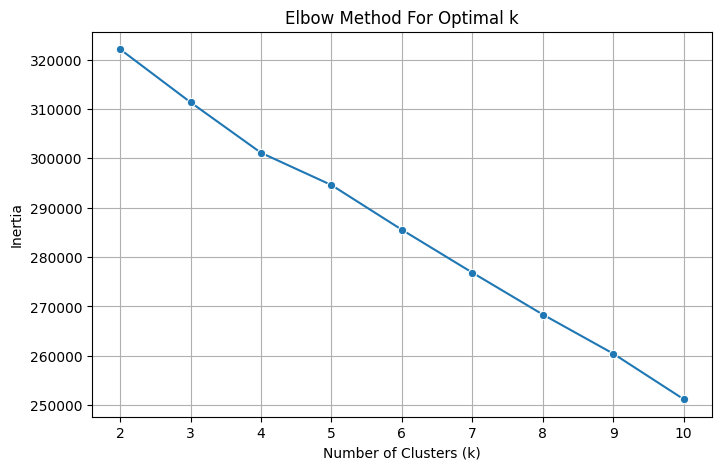

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 6.1: Elbow Method to find optimal k
inertia = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Step 6.2: Plot Elbow Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [ ]:
# Step 6.3: Final KMeans clustering
from sklearn.cluster import KMeans

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Adding cluster labels to original DataFrame
df['kmeans_cluster'] = cluster_labels

# Checking how many records in each cluster
df['kmeans_cluster'].value_counts().sort_index()

,count
kmeans_cluster,
0,1030
1,1271
2,2485
3,2984


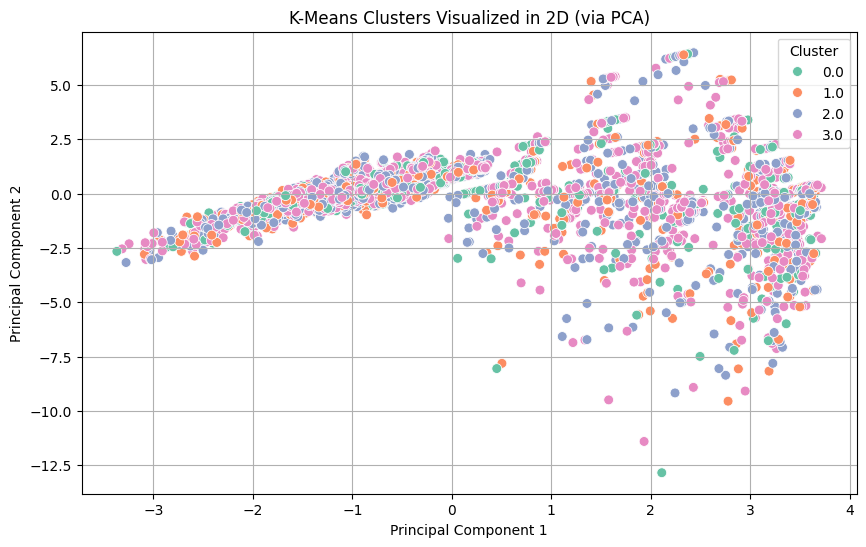

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 7: PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creating a PCA DataFrame with clusters
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['kmeans_cluster']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=50)
plt.title("K-Means Clusters Visualized in 2D (via PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluating the clustering
sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")

Silhouette Score: 0.0654
Davies-Bouldin Index: 3.3945



##Conclusion

We successfully clustered Netflix content using various clustering algorithms. KMeans performed reasonably well with 4 distinct clusters. Each cluster represents unique content themes (e.g., international TV shows, kids' content, classic movies). Evaluation scores support moderate separation, and PCA plots show distinct grouping patterns.

This clustering can help drive personalized recommendations and content categorization for viewers.
